# Lab: Generating Molecular Graphs with Variational Graph Autoencoders
## Author: Michail Chatzianastasis, Iakovos Evdaimon


## Objective
The objective of this lab is to familiarize students with Graph Neural Networks (GNNs), specifically Variational Graph Autoencoders (VGAE), and their application in generating molecular graphs. Students will gain hands-on experience with PyTorch Geometric, a library for deep learning on graph-structured data.

Graphs are ubiquitous data structures that can represent various real-world entities such as social networks, molecular structures, and communication networks. Graph Neural Networks (GNNs) have emerged as powerful tools for learning representations of graphs. In this lab, we will focus on Variational Graph Autoencoders (VGAE), a type of GNN that learns to encode graph structures into a latent space and reconstructs the graph from this space, thereby allowing the generation of new graph structures.



### Part 1: Understanding the Dataset and Preprocessing


### Dataset: ZINC
We will use the ZINC dataset, a collection of chemical compounds, for our experiments. The ZINC dataset, part of the PyTorch Geometric (PyG) collection, comprises 12,000 molecular graphs, each with up to 38 heavy atoms. In these molecular graphs, node features correspond to the types of heavy atoms, while edge features signify the kinds of bonds connecting them. Furthermore, every node within these molecular graphs symbolizes an atom, and the edges (links) between pairs of nodes denote the chemical bonds between those atoms.

In the first task you have to load the dataset and split each graph into training, validation, and test sets. This involves separating edges (bonds) for model training, validation, and testing, using [RandomLinkSplit](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomLinkSplit.html). Use num_val=0.05, num_test=0.1.


<span style="color:red"> Task 1: Load the dataset from PyG, and split the edges in train, val and test. </span>.




In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00


In [60]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import to_undirected
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [103]:
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True)
])

dataset = ZINC(root='/tmp/ZINC', subset=True, transform=transform)


### Preprocessing

<span style="color:red"> Task 2: Normalize the node features. </span>.



In [104]:
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

train_data_list, val_data_list, test_data_list = [], [], []
for train_data, val_data, test_data in dataset:
    try:
        if val_data.neg_edge_label is not None:
            train_data.x = F.normalize(train_data.x.float())
            val_data.x = F.normalize(val_data.x.float())
            test_data.x = F.normalize(test_data.x.float())
            train_data_list.append(train_data)
            val_data_list.append(val_data)
            test_data_list.append(test_data)
    except:
        continue

batch_size = 4

train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size)

### Part 2: Implementing the Variational Graph Autoencoder

- Implement a VariationalGCNEncoder using [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html) layers. This encoder will map input graph features to a latent space representation.


<span style="color:red"> Task 3: Complete the VariationalGCNEncoder class.
    Use 1 GCNConv layer to transform the node features, 1 GCNConv layer to predict the $mu$ and 1 GCNConv layer to predict the $logstd$ </span>.


In [43]:
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)

        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)

        return mu, logstd


Utilize the [VGAE](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.VGAE.html) class from PyTorch Geometric and pass your encoder to it. This model will learn to reconstruct the encoded graphs from their latent representations.


<span style="color:red"> Task 4: Initilize the VGAE model</span>.


In [44]:
from torch_geometric.nn import VGAE

in_channels = dataset.num_features
out_channels = 16

encoder = VariationalGCNEncoder(in_channels, out_channels)

model = VGAE(encoder)

print(model)

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(1, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)


### PART 3: Training the model
Implement the training loop where you will optimize the reconstruction loss and the KL divergence to train the VGAE model.

<span style="color:red"> Task 5: Complete the train, val functions below. <li style="color:red"> Encode the graphs into a latent representation z
<li style="color:red"> Computer the reconstruction loss</span>.


In [89]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train():
    model.train()
    loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        rec_loss = model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
        loss = rec_loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all += data.y.size(0) * float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)


@torch.no_grad()
def val(loader):
    model.eval()
    auc_all, ap_all = 0, 0

    for data in loader:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_all += data.y.size(0) * float(auc)
        ap_all += data.y.size(0) * float(ap)
    return auc_all / len(val_loader.dataset), ap_all / len(val_loader.dataset)




<span style="color:red"> Task 6: Train the model for 5 epochs. Print the Epoch, Train Loss, AUC and AP in the validation set in each epoch </span>.

In [90]:
## Insert your code here

n_epoch = 10
for epoch in range(n_epoch):
    loss = train()
    auc, ap = val(val_loader)
    print(f"Epoch: {epoch}, Loss: {loss}, AUC: {auc}, AP: {ap}")



Epoch: 0, Loss: 1.3523205422036013, AUC: 0.5100924072984109, AP: 0.6349564729953233
Epoch: 1, Loss: 1.3504329248903217, AUC: 0.5066957033549148, AP: 0.6332338163438842
Epoch: 2, Loss: 1.3480001121917284, AUC: 0.5149499705709241, AP: 0.6377250109775158
Epoch: 3, Loss: 1.3475659157262962, AUC: 0.5085250147145379, AP: 0.6329002494464563
Epoch: 4, Loss: 1.3474958086939963, AUC: 0.5070317834020013, AP: 0.6320111550211638
Epoch: 5, Loss: 1.3477387603133337, AUC: 0.5012642731018246, AP: 0.6277670525145544
Epoch: 6, Loss: 1.3468124462058082, AUC: 0.5035320776927605, AP: 0.6282855834898231
Epoch: 7, Loss: 1.3464684836088454, AUC: 0.5105232489699824, AP: 0.6343752534170466
Epoch: 8, Loss: 1.343675328269294, AUC: 0.5192613301942319, AP: 0.6405368237151668
Epoch: 9, Loss: 1.3449131454700158, AUC: 0.5035420835785758, AP: 0.630475536496729


## Part 4: Generate new graphs:
After training, use the model to generate new graphs. Decode the latent representations to adjacency matrices and convert these matrices to graph objects using NetworkX. Visualize the generated graphs.

<span style="color:red"> Task 7: Sample from the latent space, decode the graphs and use a threshold of 0.5 to obtain a binary adj matrix.
Visualize the generated graphs </span>.


Generate New Graphs


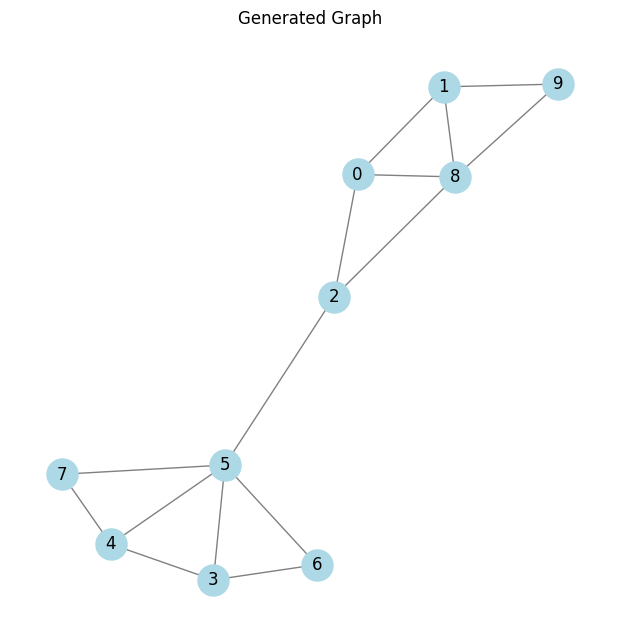

In [91]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt

print("Generate New Graphs")
add_self_loops = False

z = torch.randn((10, 16))
adj = model.decoder.forward_all(z)
adj = adj.detach().numpy()

binary_adj = (adj > 0.5).astype(int)


indices = np.where(binary_adj)
G = nx.Graph()

if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Generated Graph")
plt.show()



### Questions for Further Exploration

- Explore the impact of different latent space dimensions on the model's ability to generate valid molecular graphs.
- Experiment with different graph convolution layers (e.g., GATConv, SAGEConv) in the encoder. How do these changes affect the performance?
- Compare the statistics (degree distribution etc.) of the training and the generated graphs.

In [110]:
from torch_geometric.nn import VGAE

in_channels = dataset.num_features
out_channels = 4

encoder = VariationalGCNEncoder(in_channels, out_channels)

model = VGAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(1, 8, heads=1)
    (conv_mu): GATConv(8, 4, heads=1)
    (conv_logstd): GATConv(8, 4, heads=1)
  )
  (decoder): InnerProductDecoder()
)


In [111]:
n_epoch = 5
for epoch in range(n_epoch):
    loss = train()
    auc, ap = val(val_loader)
    print(f"Epoch: {epoch}, Loss: {loss}, AUC: {auc}, AP: {ap}")

Epoch: 0, Loss: 1.3117897697586813, AUC: 0.5169315283500098, AP: 0.6421856741126934
Epoch: 1, Loss: 1.2887330871529268, AUC: 0.5171987443594271, AP: 0.642624774610652
Epoch: 2, Loss: 1.288394168042098, AUC: 0.5175589562487737, AP: 0.6430758335902572
Epoch: 3, Loss: 1.2881759531712658, AUC: 0.516366490092211, AP: 0.6417630165269993
Epoch: 4, Loss: 1.2881610890849329, AUC: 0.5184335883853247, AP: 0.6461120547100564


Generate New Graphs


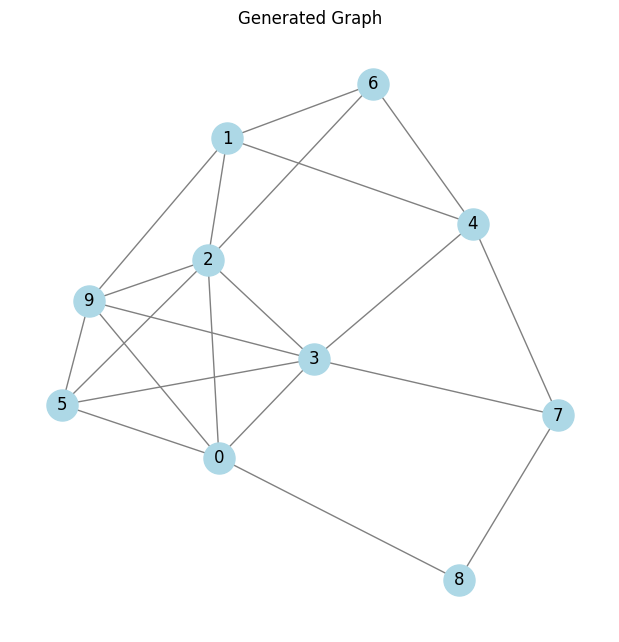

In [112]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt

print("Generate New Graphs")
add_self_loops = False

z = torch.randn((10, 4))
adj = model.decoder.forward_all(z)
adj = adj.detach().numpy()

binary_adj = (adj > 0.5).astype(int)


indices = np.where(binary_adj)
G = nx.Graph()

if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Generated Graph")
plt.show()

In [113]:
from torch_geometric.nn import GCNConv, GATConv
import torch
import torch.nn.functional as F

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels)

        self.conv_mu = GATConv(2 * out_channels, out_channels)
        self.conv_logstd = GATConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)

        return mu, logstd

In [114]:
from torch_geometric.nn import VGAE

in_channels = dataset.num_features
out_channels = 16

encoder = VariationalGCNEncoder(in_channels, out_channels)

model = VGAE(encoder)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(1, 32, heads=1)
    (conv_mu): GATConv(32, 16, heads=1)
    (conv_logstd): GATConv(32, 16, heads=1)
  )
  (decoder): InnerProductDecoder()
)


In [115]:
n_epoch = 5
for epoch in range(n_epoch):
    loss = train()
    auc, ap = val(val_loader)
    print(f"Epoch: {epoch}, Loss: {loss}, AUC: {auc}, AP: {ap}")

Epoch: 0, Loss: 1.4194638830974144, AUC: 0.5172952717284677, AP: 0.6428174182759269
Epoch: 1, Loss: 1.4047348083082967, AUC: 0.5163093976849127, AP: 0.6439124414921978
Epoch: 2, Loss: 1.4035974857174276, AUC: 0.5163441239945066, AP: 0.6440797668096112
Epoch: 3, Loss: 1.402612350631139, AUC: 0.5167331763782617, AP: 0.6417779833141846
Epoch: 4, Loss: 1.402109532443266, AUC: 0.5166531292917402, AP: 0.6441694554219605


Generate New Graphs


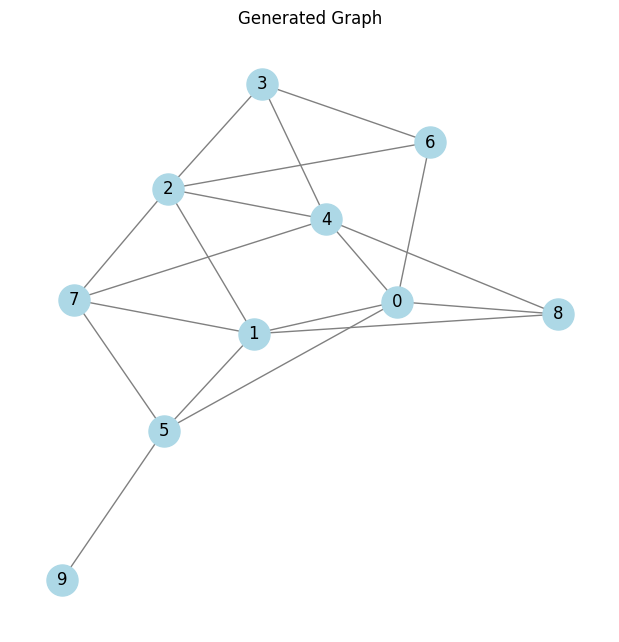

In [125]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt

print("Generate New Graphs")
add_self_loops = False

z = torch.randn((10, 32))
adj = model.decoder.forward_all(z)
adj = adj.detach().numpy()

binary_adj = (adj > 0.5).astype(int)


indices = np.where(binary_adj)
G = nx.Graph()

if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Generated Graph")
plt.show()